In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_plotting, utils_plotting_accelerometer, utils_accelerometer, utils_misc

from lib_accelerometer import ACCELEROMETER 
from lib_data import DATA_IO
from lib_statistics import NON_PARAMETRIC_TEST

PATH_CURR   = os.path.abspath(os.curdir)    # current code
PATH        = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
PATH_DATA   = PATH + "\\data"               # the recordings data directory
PATH_EVENTS = PATH + "\\events"
SUB_LIST    = utils_misc.get_SUB_list(PATH_DATA) # get the SUB id list which we have a recording of them

# 1. Extract Accelerometer Recordings of Events

In [2]:
df_accelerometer_events = pd.read_csv(DATA_IO.path_events + "EVENTS_ACC.csv")
accelerometer_events    = pd.DataFrame()

for SUB in SUB_LIST: 
    
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    patient_acc_events = patient_kinematics.extract_accelerometer_events(patient_events)

    # If the accelerometer events dictionary is empty assign the patient event dictionary to it
    if(len(accelerometer_events)==0):
        accelerometer_events = patient_acc_events

    # otherwise, merge previous patient events with current patient events 
    else:
        accelerometer_events = utils_misc.combine_dataframes(accelerometer_events, patient_acc_events)
        
accelerometer_events.to_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")

ACCELEROMETER: SUB-008
... loading started


AssertionError: FILE 008_mergedData_v4.0_acc_right.P not in c:\Users\filip\OneDrive - Charité - Universitätsmedizin Berlin\Kühn Lab\Projects\dysk_ecoglfp\data\data\sub-008

# 2. Plotting

<Figure size 640x480 with 0 Axes>

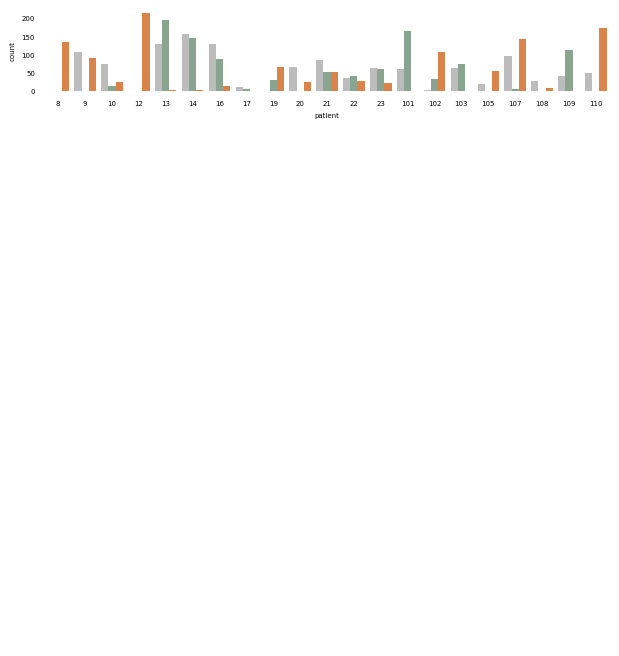

<Figure size 640x480 with 0 Axes>

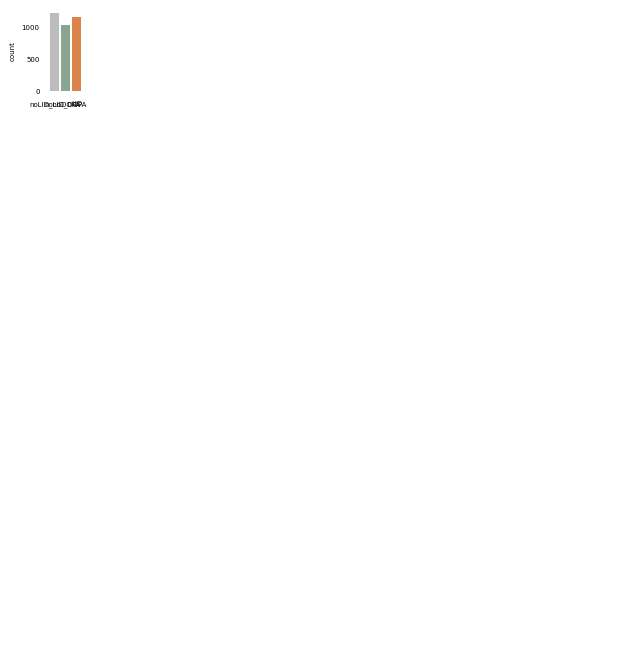

<Figure size 640x480 with 0 Axes>

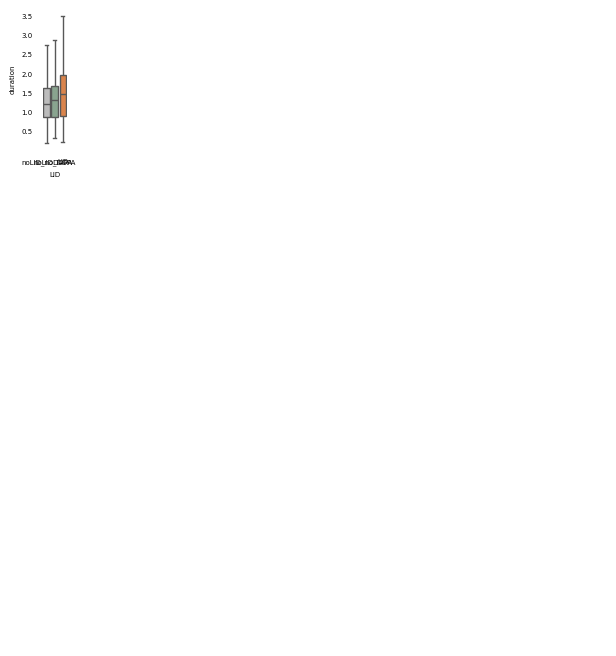

In [3]:
## 1. Load accelerometer event history of all patient
df_accelerometer_events                 = pd.read_csv(DATA_IO.path_events + "EVENTS_ACC.csv")
df_accelerometer_events                 = pd.read_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")
df_accelerometer_events["LID"] = df_accelerometer_events['dyskinesia_arm'].copy()

## chance categories into 3: noLID_noDOPA, noLID_DOPA, LID
df_accelerometer_events.loc[(df_accelerometer_events['LID']!= "none")  , "LID"] = 'LID'
df_accelerometer_events.loc[(df_accelerometer_events['LID']== "none") &
                            (df_accelerometer_events['event_start_time'] <= 30 ), "LID"] = 'noLID_noDOPA'
df_accelerometer_events.loc[(df_accelerometer_events['LID']== "none") & 
                            (df_accelerometer_events['event_start_time'] > 30 ) , "LID"] = 'noLID_DOPA'


## plotting the distribution of tapping task under different LID severity condition per patients
plt        = utils_plotting.get_figure_template()
ax_count   = plt.subplot2grid((77, 66), (0, 0) , colspan=70, rowspan=10)
ax_count   = sns.countplot(data=df_accelerometer_events, x="patient", hue="LID",  hue_order=["noLID_noDOPA","noLID_DOPA","LID"],
                           ax=ax_count, legend=False,
                           palette=[utils_plotting.colors["noLID_noDOPA"],utils_plotting.colors["noLID_DOPA"], utils_plotting.colors["LID"]])
utils_plotting.set_axis(ax_count)
plt.savefig(DATA_IO.path_figure + 'accelerometer/tap_counts_patientwise.svg', dpi=300)

## plotting the distribution of tapping task under different LID severity condition in total
plt        = utils_plotting.get_figure_template()
ax_count   = plt.subplot2grid((77, 66), (0, 0) , colspan=4, rowspan=10)
ax_count   = sns.countplot(data=df_accelerometer_events, x="LID",  order=["noLID_noDOPA","noLID_DOPA","LID"],
                           ax=ax_count, legend=False,
                           palette=[utils_plotting.colors["noLID_noDOPA"],utils_plotting.colors["noLID_DOPA"], utils_plotting.colors["LID"]])
utils_plotting.set_axis(ax_count)
plt.savefig(DATA_IO.path_figure + 'accelerometer/tap_counts_total.svg', dpi=300)

## plotting tap duration per LID severity
plt         = utils_plotting.get_figure_template()
ax_duration = plt.subplot2grid((77, 66), (0, 0) , colspan=3, rowspan=17)
ax_duration = sns.boxplot(data=df_accelerometer_events, x="LID", y="duration", order=["noLID_noDOPA","noLID_DOPA","LID"],
                          ax=ax_duration, legend=False, showfliers=False,
                          palette=[utils_plotting.colors["noLID_noDOPA"],utils_plotting.colors["noLID_DOPA"], utils_plotting.colors["LID"]])
ax_count.set_xlabel("")
utils_plotting.set_axis(ax_duration)
plt.savefig(DATA_IO.path_figure + 'accelerometer/tap_durations.svg', dpi=300)

<Figure size 640x480 with 0 Axes>

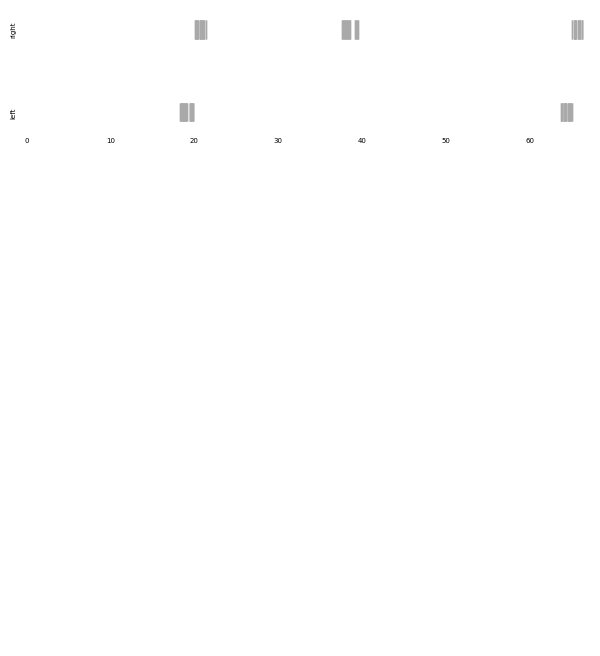

In [4]:
plt           = utils_plotting.get_figure_template()
ax_right_taps = plt.subplot2grid((77, 66), (0, 0), colspan=77, rowspan=5)
ax_left_taps  = plt.subplot2grid((77, 66), (10, 0), colspan=77, rowspan=5)

right_taps    = df_accelerometer_events[(df_accelerometer_events.patient==8) & (df_accelerometer_events.laterality=="right")].event_start_time.tolist()
left_taps     = df_accelerometer_events[(df_accelerometer_events.patient==8) & (df_accelerometer_events.laterality=="left")].event_start_time.tolist()

ax_right_taps.eventplot(right_taps, linewidths=1, lineoffsets=1, color="darkgrey") 
ax_right_taps.set_xlim([0, np.max([np.max(right_taps), np.max(left_taps)])+1])
ax_left_taps.eventplot(left_taps, linewidths=1, lineoffsets=1, color="darkgrey") 
ax_left_taps.set_xlim([0, np.max([np.max(right_taps), np.max(left_taps)])+1])

ax_right_taps.spines[['bottom', 'top', "right", "left"]].set_visible(False)
ax_left_taps.spines[['bottom', 'top', "right", "left"]].set_visible(False)

ax_right_taps.tick_params(axis='both', length=0)
ax_right_taps.set_xticklabels([])
ax_right_taps.set_yticklabels([])
ax_right_taps.set_ylabel("right", fontsize=5)
ax_left_taps.tick_params(axis='both', length=0)
ax_left_taps.set_yticklabels([])
ax_left_taps.set_ylabel("left", fontsize=5)
ax_left_taps.set_xticklabels(ax_left_taps.get_xticklabels(), fontsize=5)
plt.savefig(DATA_IO.path_figure + 'accelerometer/patient_008_taps.svg', dpi=300)

# Plot Event Categories

In [5]:
df_accelerometer_events        = pd.read_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")
df_accelerometer_events["LID"] = df_accelerometer_events['dyskinesia_arm'].copy()

## chance categories into 3: noLID_noDOPA, noLID_DOPA, LID
df_accelerometer_events.loc[(df_accelerometer_events['LID']!= "none")  , "LID"] = 'LID'
df_accelerometer_events.loc[(df_accelerometer_events['LID']== "none") &
                            (df_accelerometer_events['event_start_time'] <= 30 ), "LID"] = 'noLID_noDOPA'
df_accelerometer_events.loc[(df_accelerometer_events['LID']== "none") & 
                            (df_accelerometer_events['event_start_time'] > 30 ) , "LID"] = 'noLID_DOPA'

# removing irregular dyskinesia scores
df_accelerometer_events = df_accelerometer_events[(~df_accelerometer_events['dyskinesia_arm'].isnull()) & (~df_accelerometer_events['dyskinesia_total'].isnull())]
    
# removing non-continous events due to the artifact removal 
df_accelerometer_events = df_accelerometer_events[df_accelerometer_events.duration == (df_accelerometer_events.event_finish_index-df_accelerometer_events.event_start_index)/512]

## 1 Tapping Events - LID Severity (Arm Strategy)

### 2.1 Overall Activity

<Figure size 640x480 with 0 Axes>

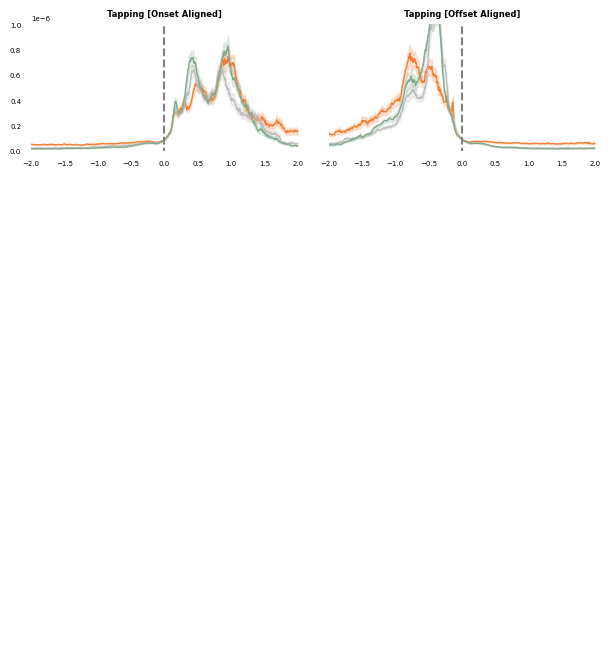

In [6]:
utils_plotting_accelerometer.plot_accelerometer_events_for_dyskinesia_severity(df_accelerometer_events, feature_severity="LID",
                                                                               event_category="tapping", dyskinesia_strategy="arm",
                                                                               figure_name=DATA_IO.path_figure + "accelerometer/tapping_dyskinesia_severity_arms")

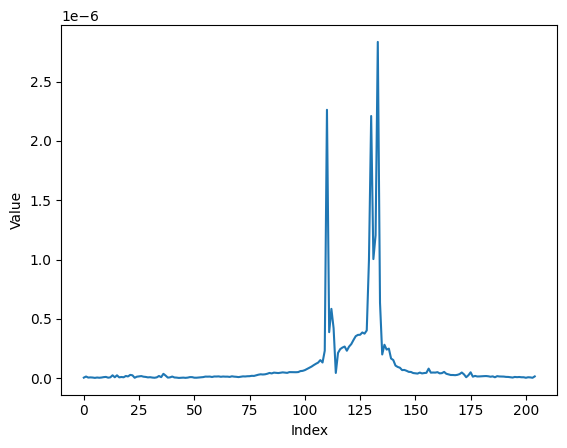

In [11]:
plt.figure()
plt.plot(df_accelerometer_events.iloc[0].event_onset_aligned[::10])
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [ ]:
df_accelerometer_events.groupby(["LID"])["patient"].nunique()

LID
LID             17
noLID_DOPA      14
noLID_noDOPA    18
Name: patient, dtype: int64